# Limpieza de PointsData-Network Devices

Los datos tal como se obtienen de sus fuentes tienen ciertas condiciones que perjudican el desempeño de los algoritmos de aprendizaje de máquina, ya sean datos faltantes, erróneos o inconsistentes, disponer de ellos previo a su ingesta por los algoritmos Machine Learning y Deep Learning, puede ser un potenciador para un mejor desempeño.

En el caso de las coordenadas geográficas, dada la relevancia que se sabe según el conocimiento del negocio, que tiene la ubicación de los equipos a la hora de determinar su comunicación efectiva o no, podría ser que ubicaciones erróneas sesguen o confundan los algoritmos al momento del entrenamiento.

Las fuentes de datos que contienen la información referente a la ubicación, son los siguientes:
    
* En archivos "report" de la carpeta cFiles.
* En los archivos de la carpeta pointsData.

In [1]:
#Importando paquetes
import os
import re
import sys
sys.path.append('../')
from Python.Preprocessing.funcs import *
from Python.FeatureEngeeniering.Fresnel.fresnelFeature import cord2disV2
import plotly.express as px
import warnings
import json
import matplotlib.pyplot as plt
import plotly
import pandas as pd
import pickle
from datetime import datetime
from Python.Style.styles import  *
from Python.Preprocessing.funcs import  *
import seaborn as sns
import plotly.graph_objs as go
from ipywidgets import interact, widgets, Output
from Python.Preprocessing.mapFuncs import Rdiscrete_map, Rdiscrete_map2, Rdiscrete_map3

In [2]:
warnings.filterwarnings("ignore")

In [3]:
pd.set_option('display.float_format',  '{:,.8f}'.format)

In [4]:
#Utilizando diseño base 1
plt.style.use('../Python/Style/style1.mplstyle')

In [5]:
#Colores base
#Diseño base
mClr = designC['cs']
mClr_d2 = plt.get_cmap('cs-d')(2)
sClr1 = designC['nr']
sClr1_d2 = plt.get_cmap('nr-d')(2)
sClr3 = designC['az']
sClr2 = designC['gr']
sClr2_d = plt.get_cmap('gr-d')(0)
sClr2_d2 = plt.get_cmap('gr-d')(2)
sClr4 = designC['vr']
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 120

## Datos de carpeta PointsData

Una red de comunicaciones desplegada en el terreno, como se ha mencionado, no es estática. En los archivos almacenados de manera automática en la carpeta pointsData pueden existir discrepancias, la validación de estos datos se realiza a continuación, considerando que se tienen las siguientes fuentes de datos:

* Información de MG, MR y MC en la carpeta PointsData.
* Información de las distintas rondas en la carpeta roundsControl.

In [6]:
#Obteniendo lista de archivos en la carpeta PointsData
pData = getNames("../Data/DataLake/PointsData",".json")

In [ ]:
#Leyendo datos de procesamiento automático
prqFiles2 = getNames(r"../Data/DataLake/pointsData",".json")

jdf = pd.DataFrame({'path':prqFiles2, 'name' : ['']*len(prqFiles2)})

jdf["dType"] = jdf["path"].str.extract("([a-z]+)-")

jdf["fDate"] = jdf["path"].str.extract("([0-9]+.[0-9]+.[0-9]+)")

jdf.head()

In [8]:
#creando dataFrames de "dataPoints" 

cList = jdf[jdf["dType"]=="colectores"]["path"]
rList = jdf[jdf["dType"]=="routers"]["path"]
mList = jdf[jdf["dType"]=="meters"]["path"]

cContainer = createContainer(cList,".json")
rContainer = createContainer(rList,".json")
mContainer = createContainer(mList,".json")

In [9]:
#Leyendo información de rondas
rondFiles = getNames(r"../Data/DataLake/roundsControl",".json")
flag = True
roundsDic = {}
cnt = 0
for i in rondFiles:
    cnt += 1
    tRow = {}
    #Leyendo json
    with open(i, "r") as f:
        tDic = json.load(f)
        f.close()
    #print(tDic)
    #Fechas de ronda
    tRow["fDate"] = tDic["fDate"]
    tRow["lDate"] = tDic["lDate"]
    tRow["round"] = "pData_{}".format(cnt)

    #tRow["routers"] = tDic["routers"]
    
    tMeters = []
    for j in range(5):
        #Agregando clients a lista
        tMeters = tMeters + tDic[str(j)][0]
        tMeters = tMeters + tDic[str(j)][1]

    #Agregando información a roundsDic
    trDic = {}
    trDic["routers"] = tDic["routers"]
    trDic["meters"] = tMeters
    roundsDic["pData_{}".format(cnt)] = trDic

    #Creando DataFrame
    tdf = pd.DataFrame(tRow, columns = ["fDate","lDate", "round"], index = [1])
    if flag:
        roundsDf = tdf
        flag = False
    else:
        roundsDf = pd.concat([roundsDf,tdf], ignore_index = True)


#Convirtiendo fechas a datetime
roundsDf["fDate"] = pd.to_datetime(roundsDf["fDate"], format = "%Y-%m-%d")
#Mostrando roundsDf
roundsDf.head()
#roundsDf.to_parquet("../Data/DataLake/roundsControl/roundsDf.parquet")

,fDate,lDate,round
0,2023-02-19,2023-02-27,pData_1
1,2023-02-27,2023-03-06,pData_2
2,2023-03-06,2023-03-13,pData_3
3,2023-03-13,2023-03-20,pData_4
4,2023-03-20,2023-03-27,pData_5


### Mesh gateways

In [10]:
#Temporal durante desarrollo
backcc = cContainer.copy()#
#cContainer = tbackcc.copy()
#cContainer.to_csv("cContainer.csv", index = False)

In [ ]:

#Leyendo fecha de fName
pattern = r"([0-9]{4}-[0-9]{2}-[0-9]{2})"
cContainer["fDate"] = cContainer["fName"].str.extract(pattern)
cContainer["fDate"] = pd.to_datetime(cContainer["fDate"], format = "%Y-%m-%d")
cContainer["fDate"] = cContainer["fDate"].dt.date
cContainer["fDate"] = pd.to_datetime(cContainer["fDate"])
#Redondeando latitud y longitud
cContainer["latitude"] = cContainer["latitude"].round(8)
cContainer["longitude"] = cContainer["longitude"].round(8)
#Modificando estampas de tiempo
def modTime(x):
    try:
        return datetime.fromtimestamp(int(x)/1000)
    except:
        return np.nan

cContainer["onBatteryBackupTimeStamp"] = cContainer["onBatteryBackupTimeStamp"].apply(modTime)
cContainer["LastPacketReceived"] = cContainer["LastPacketReceived"].apply(modTime)
cContainer["LastStatusChanged"] = cContainer["LastStatusChanged"].apply(modTime)
#Eliminando columnas innecesarias
cContainer.drop(["altitude","ipAddress","notes"], axis = 1, inplace = True)

#Identificando cambios entre fechas
cContainer = detect_changes(cContainer, ["collectorId","serialNumber","radio"],["CollectorNm","StatusCode","latitude","longitude"])

#Identificando coordenadas duplicadas para validación
cContainer["Dup"] = "NoDup"
cContainer.loc[cContainer.duplicated(subset = ["latitude","longitude","fDate"], keep = False), "Dup"] = "Dup"



#Agregando columna de ronda
for i, row in roundsDf.iterrows():
    mask = (cContainer["fDate"] >= row["fDate"]) & (cContainer["fDate"] < row["lDate"])
    cContainer.loc[mask,"round"] = row["round"]
#Quitando hora de fDate
cContainer["fDate"] = cContainer["fDate"].dt.date
cContainer.head()

#### Visualización de mesh gateways

##### Coordenadas duplicadas

In [12]:
#Función para mapas discretos
#Variables
#Leyendo token de pickle
with open("../Private/mapboxToken.pickle", "rb") as f:
    mapbox_access_token = pickle.load(f)

#Widgets de entrada
fDate = widgets.SelectionSlider(options = list(cContainer["fDate"].unique()), description = "Fecha")
#CollectorNm = widgets.Dropdown(options = list(cContainer["CollectorNm"].unique()), description = "Collector")

clrDic = {"Dup" : sClr1, "NoDup" : sClr3}
wgDic = {"fDate":fDate}#,"CollectorNm":CollectorNm

In [13]:
#Función para mapas discretos
Rdiscrete_map(cContainer,clrDic,"Dup",wgDic,"Mesh Gateways DupCoords")

Output()

interactive(children=(SelectionSlider(description='Fecha', options=(datetime.date(2023, 2, 19), datetime.date(…

In [14]:
#Widgets de entrada
fDate2 = widgets.SelectionSlider(options = list(cContainer["fDate"].unique()), description = "Fecha")
clrDic2 = {"Cambio" : sClr1, "NoCambio" : sClr3}
wgDic2 = {"fDate":fDate2}#,"CollectorNm":CollectorNm

In [15]:
#Mapa de cambios en mesh gateway
Rdiscrete_map(cContainer,clrDic2,"Change",wgDic2,"Mesh Gateways Cambios")

Output()

interactive(children=(SelectionSlider(description='Fecha', options=(datetime.date(2023, 2, 19), datetime.date(…

Las visualizaciones anteriores están pensadas en conseguir la identificación de los casos que puedan tener coordenadas erróneas. Se guarda un archivo csv en el área de espera del lago de datos, con la finalidad de que un proceso de asignación de datos de parte del usuario consiga corregir los posibles errores o en su defecto, acondicionar los casos como sea pertinente.

In [16]:
#Almacenando dataset para su revisión manual
cContainer["toDelete"] = False
cContainer["Rev"] = False
cContainer["Comment"] = ""
#cContainer.to_csv("../Data/DataLake/cleaningStage/cContainer-issues-20-5-2023.csv", index = False)

Debido a que la cantidad es menor y que estos equipos son en la mayoría de los casos estáticos, la validación de los datos se hará con un "análisis manual", que en las circunstancias actuales no es más que usar la inteligencia humana para identificar problemas y corregirlos, en lugar de usar una IA.

In [17]:
#Agregando correcciones a cContainer
#Leyendo arrchivo corregido
fixcContainer = pd.read_csv("../Data/DataLake/cleaningStage/cContainer-issues-20-5-2023-rev.csv", parse_dates=['fDate'])
#Seleccionando filas de interés
#fixcContainer = fixcContainer[["serialNumber","fName","latitude","longitude",\
#                               "toDelete","Rev","Comment"]]
#Redondeando coordenadas
fixcContainer[["latitude","longitude"]] = fixcContainer[["latitude","longitude"]].round(8)
#Agregando correcciones a cContainer
cContainer = updateDf(cContainer,fixcContainer,["serialNumber","fName"],["latitude","longitude",\
                            "toDelete","Rev","Comment"])
#cContainer.to_csv("../Data/DataLake/temp/cContainer-26-5-2023.csv",index = False)

In [18]:
#Almacenando cContainer en carpeta Base de DataMart
#cContainer.to_parquet("../Data/DataMart/Base/cContainer.parquet", index = False)

El archivo corregido será una referencia para las siguientes fases de detección de información errónea. Dado que la estrategia es ir descendiendo en la jerarquía  de equipos de red, el siguiente equipo a trabajar serán los Mesh Routers.

### Mesh routers

In [19]:
#Referencia de meshGateways
mgRef = pd.read_parquet("../Data/DataMart/Base/cContainer.parquet")
#mgRef = cContainer[cContainer["toDelete"] != True]
#Confirmando eliminación de duplicados
print("Duplicados luego de correción: {}".format(mgRef.duplicated(subset = ["latitude","longitude","fDate"]).sum()))
#Los cambios fueron validados manualmente y puede que algunos se mantengan y no tengan etiqueta para eliminar.

Duplicados luego de correción: 427


Los datos de los mesh router que son de interés en este punto son los que corresponden a la ubicación geográfica, su poste de referencia, su mesh gateway asociado y su mejor vecino. Esto permitirá identificar si algún router muestra información incorrecta, al igual que en el caso de los colectores el objetivo de este tratamiento es entregar un dataset con etiquetas que permitan una verificación manual, aunque en este caso se utilizará la estadística como herramienta para la identificación de posibles fallas.

Con respecto al mejor vecino, puede darse el caso, dada la naturaleza de la red mesh y a su software de enrutamiento, que un mesh router utilice un mesh client como mejor vecino. Dado que la información de los mesh clients aún no se ha validado, se utilizará la estrategia siguiente.

### Generando datos para análisis de Mesh Routers

In [ ]:
#Agregando fDate a tRContainer
tRContainer = rContainer.copy()
tRContainer["fDate"] = tRContainer["fName"].str.extract(pattern)
tRContainer["fDate"] = pd.to_datetime(tRContainer["fDate"], format = "%Y-%m-%d")
#Agregando columna de ronda a tRContainer
for i, row in roundsDf.iterrows():
    mask = (tRContainer["fDate"] >= row["fDate"]) & (tRContainer["fDate"] < row["lDate"])
    tRContainer.loc[mask,"round"] = row["round"]
#tRContainer = tRContainer.merge(roundsDf[["fDate","round"]], on = "fDate", how = "left")
#Extrayendo polo de poleNo
tRContainer["poleNo"] = tRContainer["poleNo"].str.extract(r"([0-9]{6})")
#tRContainer.to_csv("../Data/DataLake/temp/rContainerV2-22-5-2023.csv", index = False)
tRContainer.head(3)

In [ ]:
#Agregando coordenadas de gateway a rContainer
tRContainer["fDate"] = tRContainer["fDate"].astype(str)
mgRef["fDate"] = mgRef["fDate"].astype(str)
tRContainer = tRContainer.merge(mgRef[["CollectorNm","fDate","latitude","longitude"]],\
                                 how = "left", on = ["CollectorNm","fDate"], suffixes = ("","_gw"))
#Validando falta de coordenadas colector
print("Colectores sin coordenadas: {}".format(tRContainer["latitude_gw"].isna().sum()))
#Calculando distancia entre routers y su correspondiente gateway
tRContainer["cDist"] = tRContainer.apply(lambda x: cord2disV2(x["latitude"],x["longitude"],x["latitude_gw"],x["longitude_gw"]), axis = 1)
#tRContainer.to_csv("../Data/DataLake/temp/rContainerV3-22-5-2023.csv", index = False)
tRContainer.head(3)

In [22]:
#Creando backup temporal, útil para desarrollo
# Verificar y crear el DataFrame de backup 'tMCbackup'
if 'tMCbackup' not in globals() or not isinstance(tMCbackup, pd.DataFrame):
    tMCbackup = mContainer.copy()
else:
    mContainer = tMCbackup.copy()
# Verificar y crear el DataFrame de backup 'tRCbackup'
if 'tRCbackup' not in globals() or not isinstance(tRCbackup, pd.DataFrame):
    tRCbackup = tRContainer.copy()
else:
    tRContainer = tRCbackup.copy()

In [ ]:
#Agregando fDate a mContainer
mContainer["fDate"] = mContainer["fName"].str.extract(pattern)
mContainer["fDate"] = pd.to_datetime(mContainer["fDate"], format = "%Y-%m-%d")
mContainer["fDate"] = mContainer["fDate"].dt.date
#Preparando referencia de mejor vecino
tempMG = cContainer[["serialNumber","fDate","latitude","longitude"]].copy()#
tempMG["devType"] = "MG"
tempMC = mContainer[["serialNumber","fDate","latitude","longitude"]].copy()#
tempMC["devType"] = "MC"
tempRC = tRContainer[["serialNumber","fDate","latitude","longitude"]].copy()#
tempRC["devType"] = "MR"
#Agregando neighbourSN a tRContainer
enSN = pd.read_csv("../Data/DataLake/cFiles/endpointSerialN.csv")
enSN.columns = ["NeighbourEndpointId","neighborSN"]
enSN["NeighbourEndpointId"] = enSN["NeighbourEndpointId"].astype(object)
#Agregando neighbourSN a tRContainer
tRContainer = tRContainer.merge(enSN, on = "NeighbourEndpointId", how = "left")
#Concatenando referencias de vecinos
tempNeigh = pd.concat([tempMG,tempMC,tempRC], ignore_index = True)
#Eliminando dfs temporales
del tempMG, tempMC, tempRC
#Modificando tipo de fecha
tempNeigh["fDate"] = tempNeigh["fDate"].astype(str)
tRContainer["fDate"] = tRContainer["fDate"].astype(str)
#Modificando tipo de serialNumber
tempNeigh["serialNumber"] = tempNeigh["serialNumber"].astype(str)
tRContainer["neighborSN"] = tRContainer["neighborSN"].astype(str)
tRContainer = tRContainer.merge(tempNeigh,\
                                how = "left", left_on = ["neighborSN","fDate"], right_on = \
                                    ["serialNumber","fDate"], suffixes = ("","_neigh"))
                                
tRContainer.head(3)

Se identificaron algunos serialNumber de mejor vecino sin su correspondiente en el df tempNeigh, analizando los casos parece ser que hubo una falla con la actualización del dato de mejor vecino en la base de datos, para estos casos en específico se obtendrá el mejor vecino basándose en el primer salto de la columna path.

In [ ]:
#Determinando vecinos sin match con serialNumber para su validación manual
rSNVal = tRContainer[(tRContainer["serialNumber_neigh"].isna()) & \
                      (tRContainer["NeighbourEndpointId"].notna())].copy()
#Obteniendo mejor vecino de path
rSNVal["neighborSN"] = rSNVal["path"].str.split(",").str[-2]
#Eliminando columnas a ser reemplazadas
rSNVal.drop(columns = ["serialNumber_neigh","latitude_neigh","longitude_neigh",\
                       "devType"], inplace = True)
#Agregando columnas reemplazadas con nuevo mejor vecino
rSNVal = rSNVal.merge(tempNeigh, how = "left", left_on = ["neighborSN","fDate"],\
                        right_on = ["serialNumber","fDate"], suffixes = ("","_neigh"))
#Guardando archivo de referencia para revisión manual
#rSNVal.to_csv("../Data/DataLake/cleaningStage/rSNVal.csv", index = False)
#Se realiza una revisión manual de los problemas identificados en esta sección
rSNVal.head(3)

In [25]:
#Agregando información validada a df principal
#Leyendo archivo modificado manual mente de cleaningStage
revRSN = pd.read_csv("../Data/DataLake/cleaningStage/rSNVal-rev.csv")
#revRSN = revRSN[["serialNumber","fName","neighborSN","serialNumber_neigh",\
#                 "latitude_neigh","longitude_neigh","devType"]]
#Redondeando coordenadas
revRSN["latitude_neigh"] = revRSN["latitude_neigh"].round(8)
revRSN["longitude_neigh"] = revRSN["longitude_neigh"].round(8)
#Actualizando df principal
tRContainer = updateDf(tRContainer,revRSN,["serialNumber","fName"],["neighborSN","serialNumber_neigh",\
                "latitude_neigh","longitude_neigh","devType"])
#Guardando para inspección visual
#tRContainer.to_csv("../Data/DataLake/temp/rContainerMOD2.csv", index = False)

Luego de las revisiones previas existen datos vacios que requieren una imputación, para ese procedimiento se identifican los casos vacíos, se generan archivos para agregación manual y luego se actualizan estos datos en el df principal (tRContainer)

In [26]:
#Routers sin poste
rNoPoste = tRContainer[tRContainer["poleNo"].isna()].copy()
#Guardando en cleaningStage
rNoPoste.to_csv("../Data/DataLake/cleaningStage/rNoPoste.csv", index = False)

In [27]:
#Agregando postes faltantes a tRContainer
rRevPoste = pd.read_csv("../Data/DataLake/cleaningStage/rNoPoste-rev.csv")
#Seleccionando columnas de interés
#rRevPoste = rRevPoste[["serialNumber","fName","poleNo"]]
#Actualizando df principal
tRContainer = updateDf(tRContainer,rRevPoste,["serialNumber","fName"],["poleNo"])
#Guardando para inspección visual
#tRContainer.to_csv("../Data/DataLake/temp/trContainer-MOD3.csv", index = False)

Por último es necesario completar coordenadas que aún se mantienen vacías, considerando que hay dos pares de coordenadas en este punto en el dataset tRContainer, las coordenadas referentes al equipo en sí, y las coordenadas correspondientes al vecino.

In [28]:
#Mesh routers sin coordenadas
nRC1 = tRContainer[(tRContainer["latitude"].isna()|tRContainer["longitude"].isna())]
#Guardando en cleaningStage
nRC1.to_csv("../Data/DataLake/cleaningStage/nRC1.csv", index = False)

In [29]:
#Agregando coordenadas faltantes a tRContainer
nRC1Rev = pd.read_csv("../Data/DataLake/cleaningStage/nRC1-rev.csv")
#Seleccionando columnas de interés
#nRC1Rev = nRC1Rev[["serialNumber","fName","latitude","longitude"]]
#Actualizando df principal
tRContainer = updateDf(tRContainer,nRC1Rev,["serialNumber","fName"],["latitude","longitude"])
#Guardando para inspección visual
#tRContainer.to_csv("../Data/DataLake/temp/trContainer-MOD4.csv", index = False)

In [30]:
#Vecino sin coordenadas
nRC2 = tRContainer[((tRContainer["latitude_neigh"].isna()|tRContainer["longitude_neigh"]\
                     .isna()) & (tRContainer["NeighbourEndpointId"].notna()))]
#Guardando en cleaningStage
#nRC2.to_csv("../Data/DataLake/cleaningStage/nRC2.csv", index = False)

In [31]:
#Actualizando a partir de nRC2-rev.csv
nRC2Rev = pd.read_csv("../Data/DataLake/cleaningStage/nRC2-rev.csv")
#Seleccionando columnas de interés
#nRC2Rev = nRC2Rev[["serialNumber","fName","serialNumber_neigh","latitude_neigh","longitude_neigh"]]
#Actualizando df principal
tRContainer = updateDf(tRContainer,nRC2Rev,["serialNumber","fName"],["serialNumber_neigh","latitude_neigh","longitude_neigh"])
#Guardando para inspección visual
#tRContainer.to_csv("../Data/DataLake/temp/trContainer-MOD5.csv", index = False)

In [ ]:
#Imputando para mesh routers con neighnhborEndpointId = NA
#Seleccionando filas
rSNVal2 = tRContainer[tRContainer["NeighbourEndpointId"].isna()].copy()
#Obteniendo mejor vecino de path
def getHop(x):
    tL = x.split(",")
    if len(tL) > 2:
        return tL[-2]
    elif len(tL) == 2:
        return tL[1]
    elif len(tL) == 1:
        return tL[0]

rSNVal2["neighborSN"] = rSNVal2["path"].apply(getHop)
#Eliminando columnas a ser reemplazadas
rSNVal2.drop(columns = ["serialNumber_neigh","latitude_neigh","longitude_neigh",\
                        "devType"], inplace = True)
#Agregando columnas reemplazadas con nuevo mejor vecino
rSNVal2 = rSNVal2.merge(tempNeigh, how = "left", left_on = ["neighborSN","fDate"],\
                        right_on = ["serialNumber","fDate"], suffixes = ("","_neigh"))
#Guardando archivo de referencia para revisión manual
rSNVal2.to_csv("../Data/DataLake/cleaningStage/rSNVal2.csv", index = False)
#Se realiza una revisión manual de los problemas identificados en esta sección
rSNVal2.head(3)

In [ ]:
#Actualizando a partir de rSNVal2-rev.csv
rSNVal2Rev = pd.read_csv("../Data/DataLake/cleaningStage/rSNVal2-rev.csv")
#Seleccionando columnas de interés
#rSNVal2Rev = rSNVal2Rev[["serialNumber","fName","neighborSN","serialNumber_neigh",\
#                            "latitude_neigh","longitude_neigh","devType"]]
#Actualizando df principal
tRContainer = updateDf(tRContainer,rSNVal2Rev,["serialNumber","fName"],["neighborSN","serialNumber_neigh",\
                            "latitude_neigh","longitude_neigh","devType"])
#Guardando para inspección visual
tRContainer.to_csv("../Data/DataLake/temp/trContainer-MOD6.csv", index = False)
tRContainer.head(3)

In [ ]:
#Calculando distancia entre mesh routers y mejor vecino
tRContainer["dist_neigh"] = tRContainer.apply(lambda x: cord2disV2(x["latitude"],\
                    x["longitude"],x["latitude_neigh"],x["longitude_neigh"]), axis = 1)

tRContainer.head(3)

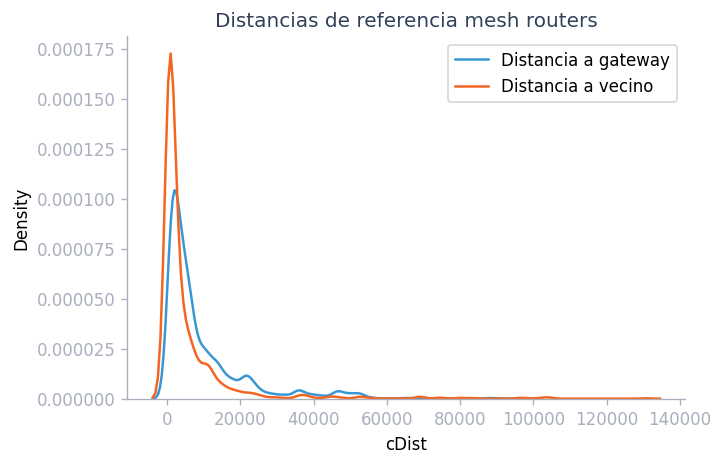

In [35]:
#Visualizando distribuciones de distancias
sns.kdeplot(tRContainer["cDist"], color = mClr)#, shade = True
sns.kdeplot(tRContainer["dist_neigh"], color = sClr1)#, shade = True
plt.legend(["Distancia a gateway","Distancia a vecino"])
plt.title("Distancias de referencia mesh routers")
plt.savefig("../Python/PythonGImages/distRefMR_density.png", dpi = 300, bbox_inches = "tight")

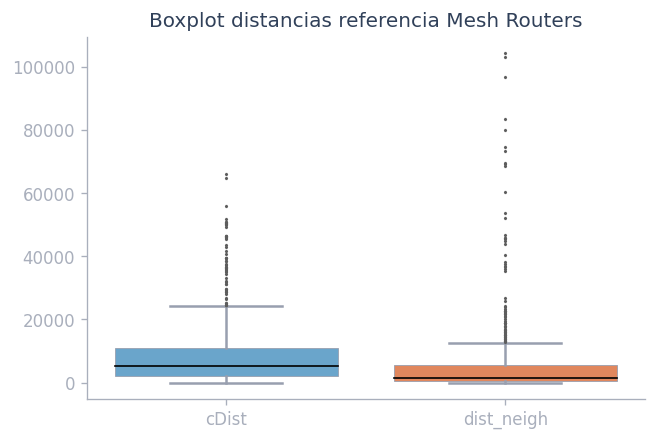

In [36]:
#Visualizando boxplot
tempDf = tRContainer[tRContainer["fDate"] == "2023-03-15"]
whiskerprops = dict(color=sClr2)
capprops = dict(color=sClr2)
boxprops = dict(edgecolor = sClr2, linewidth=0.5)
medianprops = dict(color = "black", linewidth=1)

ax = sns.boxplot(data = tempDf[["cDist","dist_neigh"]], palette = [mClr_d2,sClr1_d2],\
             fliersize = 1, whiskerprops=whiskerprops,\
            capprops = capprops, boxprops = boxprops, medianprops = medianprops)#

plt.title("Boxplot distancias referencia Mesh Routers")
plt.savefig("../Python/PythonGImages/distRefMR_boxplot.png", dpi = 300, bbox_inches = "tight")
plt.show()

In [37]:
#Detectando outliers en tRContainer
tRContainer["neigh_outlier"] = outliers_detector(tRContainer["dist_neigh"])
tRContainer["gw_outlier"] = outliers_detector(tRContainer["cDist"])
#Determinando si es outlier en alguna de las columnas anteriores
tRContainer["outlier"] = tRContainer.apply(lambda x: "outlier" if x["neigh_outlier"] == "outlier"\
                        or x["gw_outlier"] == "outlier" else "normal", axis = 1)
#Guardando para inspección visual
#tRContainer.to_csv("../Data/DataLake/temp/trContainer-MOD17.csv", index = False)

Se aprecia en ambas gráficas que la distribución de las distancias está mayoritariamente cercana a la media y a la mediana. Los valores atípicos son aquellos que se extienden más allá de la cota superior, que representa junto con la cota inferior, un ancho de 1.5 veces el rango inter cuantil.

Siendo que esta detección se hace por métodos estadísticos, este será el criterio para la selección de los valores que serán validados debido a que se consideran con mayor probabilidad de ser datos erróneos.

In [ ]:
#Detectando outliers
tRContainer["n_outliers"]= identificar_outliers(tRContainer["dist_neigh"])
nn_outliers = tRContainer["n_outliers"].value_counts()
tRContainer["g_outliers"]= identificar_outliers(tRContainer["cDist"])
gn_outliers = tRContainer["g_outliers"].value_counts()
tRContainer["outliers"] = tRContainer["n_outliers"] + tRContainer["g_outliers"]
#Guardando para validación manual
tRContainer["toDelete"] = False
tRContainer["Rev"] = False
tRContainer["Comment"] = ""
#tRContainer.to_csv("../Data/DataLake/cleaningStage/trContainer_woutliers.csv", index = False)
tRContainer.head(3)

### Visualizando mesh routers en mapa

Se utiliza un mapa de plotly para visualizar los outliers con referencia a su mesh gateway correspondiente y en una determinada fecha. Con esta ayuda visual se facilita la revisión manual de los outliers con el fin de corregir los posibles datos erróneos.

In [39]:
#Parámetros de mapa
#Widgets
fDate3 = widgets.SelectionSlider(options = list(tRContainer["fDate"].unique()), description = "Fecha")
collectorNm = widgets.Dropdown(options = list(tRContainer["CollectorNm"].unique()),description = "Collector")
clrDic3 = {"outlier": sClr1, "normal": sClr3}
wgDic3 = {"fDate":fDate3, "CollectorNm":collectorNm}#
dicTemp1 = {
    
    "routers" : [tRContainer, clrDic3, "outlier",["radio","neighborSN"]],
    "gateways" : [mgRef, mClr, None,["CollectorNm"]]

}

In [40]:
#Visualización de mapa interactivo
Rdiscrete_map2(dicTemp1, wgDic3, "Mesh Routers Outliers")

Output()

interactive(children=(SelectionSlider(description='Fecha', options=('2023-02-19', '2023-02-20', '2023-02-21', …

In [41]:
#Parámetros de mapa
#Widgets
fDate4 = widgets.SelectionSlider(options = list(tRContainer["fDate"].unique()), description = "Fecha")
routrR = widgets.Dropdown(options = list(tRContainer["radio"].unique()),description = "radio")
clrDic3 = {"outlier": sClr1, "normal": sClr3}
#clrDic3 = {True: sClr1, False: sClr3}
wgDic4 = {"radio":routrR}#"fDate":fDate4, 
dicTemp2 = {
    "vecino" : [tRContainer, clrDic3, "neigh_outlier",["neighborSN"]],
    "router" : [tRContainer, mClr, None,["radio"]]
    
    #"routers" : [tRContainer, clrDic3, "outlier",["radio","neighborSN"]],
}

In [42]:
#Visualización de mapa interactivo
Rdiscrete_map2(dicTemp2, wgDic4, "Mesh Routers Outliers")

Output()

interactive(children=(Dropdown(description='radio', options=('807F405F', '8061CD07', '8061CE8C', '8061CC2D', '…

### Outliers por router

In [43]:
#Parámetros de mapa
#Widgets
fDate4 = widgets.SelectionSlider(options = list(tRContainer["fDate"].unique()), description = "Fecha")
routrR = widgets.Dropdown(options = sorted(list(tRContainer["radio"].unique())),description = "radio")
clrDic3 = {"outlier": sClr1, "normal": sClr3}
clrDic4 = {"outlier"}
#clrDic3 = {True: sClr1, False: sClr3}
wgDic5 = {"radio":routrR}#"fDate":fDate4, 
dicTemp4 = {
    "vecino" : [tRContainer, clrDic3, "neigh_outlier",["neighborSN"],["latitude_neigh","longitude_neigh"]],
    "gway" : [tRContainer, sClr4, None,["CollectorNm"],["latitude_gw","longitude_gw"]],
    "router" : [tRContainer, mClr, None,["radio"],["latitude","longitude"]]
    
    #"routers" : [tRContainer, clrDic3, "outlier",["radio","neighborSN"]],
}

In [44]:
#Visualización de mapa interactivo
Rdiscrete_map3(dicTemp4, wgDic5, "Mesh Routers Outliers")

Output()

interactive(children=(Dropdown(description='radio', options=('80614B66', '80614B67', '8061C545', '8061C546', '…

In [65]:
#Visualización de todos los equipos
#Widgets
fDate5 = widgets.SelectionSlider(options = list(tRContainer["fDate"].unique()), description = "Fecha")
routrR = widgets.Dropdown(options = sorted(list(tRContainer["radio"].unique())),description = "radio")
clrDic4 = {"outlier": sClr1, "normal": sClr3}
#clrDic3 = {True: sClr1, False: sClr3}
wgDic6 = {"fDate":fDate5}#"fDate":fDate4, 
dicTemp5 = {
    "vecino" : [tRContainer, clrDic4, "outlier",["radio"],["latitude","longitude"]]
    #"routers" : [tRContainer, clrDic3, "outlier",["radio","neighborSN"]],
}

In [66]:
#Visualización de mapa interactivo
Rdiscrete_map3(dicTemp5, wgDic6, "Mesh Routers Outliers")

Output()

interactive(children=(SelectionSlider(description='Fecha', options=('2023-02-19', '2023-02-20', '2023-02-21', …

### Agragando resultados de revisión manual

In [ ]:
#Leyendo archivo de correcciones
fixrContainer = pd.read_csv("../Data/DataLake/cleaningStage/trContainer_woutliers-rev.csv")
fixrContainer.head(3)

### Imputando valores a routers

In [46]:
#Actualizando columnas toDelete, Rev y Comment
fixrContainer["latitude_neigh"] = fixrContainer["latitude_neigh"].round(8)
fixrContainer["longitude_neigh"] = fixrContainer["longitude_neigh"].round(8)
tRContainer = updateDf(tRContainer,fixrContainer,["serialNumber","fName"],["toDelete","Rev","Comment"])

In [47]:
#Etiqueta BadNeigh e invNeigh
print(sum(tRContainer.loc[(tRContainer["Comment"] == "BadNeigh") | (tRContainer["Comment"] == "invNeigh"), "LogDTM"].isna()))
tempBadN = tRContainer.loc[(tRContainer["Comment"] == "BadNeigh") | (tRContainer["Comment"] == "invNeigh")].copy()
#Adquiriendo vecino de Path
tempBadN["neighborSN"] = tempBadN["path"].apply(getHop)
#Agregando coordenadas de vecino
orderCols = tempBadN.columns
tempBadN.drop(columns = ["latitude_neigh","longitude_neigh","devType","serialNumber_neigh"], inplace = True)
tempBadN = tempBadN.merge(tempNeigh, how = "left", left_on = ["neighborSN","fDate"],\
                        right_on = ["serialNumber","fDate"], suffixes = ("","_neigh"))

tempBadN = tempBadN[orderCols]
tempBadN.head(3)
#tempBadN.to_csv("../Data/DataLake/temp/tempBadN.csv", index = False)
#Actualizando df principal
tRContainer = updateDf(tRContainer,tempBadN,["serialNumber","fName"],["neighborSN","serialNumber_neigh","latitude_neigh","longitude_neigh","devType"])
#Guardando para inspección visual
tRContainer.to_csv("../Data/DataLake/temp/trContainer-MOD8.csv", index = False)

0


In [48]:
#Etiqueta badNC
tRContainer.loc[tRContainer["Comment"] == "badNC", "latitude_neigh"] = np.nan
tRContainer.loc[tRContainer["Comment"] == "badNC", "longitude_neigh"] = np.nan
#Guardando para inspección visual
tRContainer.to_csv("../Data/DataLake/temp/trContainer-MOD9.csv", index = False)

In [49]:
#Etiqueta fixNeigC
tempFixN = fixrContainer.loc[fixrContainer["Comment"] == "fixNeigC"].copy()
#Actualizando df principal
tRContainer = updateDf(tRContainer,tempFixN,["serialNumber","fName"],["latitude_neigh","longitude_neigh"])
#Guardando para inspección visual
tRContainer.to_csv("../Data/DataLake/temp/trContainer-MOD10.csv", index = False)

In [50]:
tRContainer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63202 entries, 0 to 63201
Data columns (total 43 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   meterNo              63202 non-null  object 
 1   radio                63202 non-null  object 
 2   serialNumber         63202 non-null  int64  
 3   CollectorNm          63202 non-null  object 
 4   name                 63202 non-null  object 
 5   latitude             63202 non-null  float64
 6   longitude            63202 non-null  float64
 7   altitude             63184 non-null  float64
 8   poleNo               63202 non-null  object 
 9   LastPacketReceived   63202 non-null  int64  
 10  LastStatusChanged    63202 non-null  int64  
 11  NoCommunicatingDays  63202 non-null  int64  
 12  layer                63165 non-null  float64
 13  numberOfNeighbors    63100 non-null  float64
 14  path                 63202 non-null  object 
 15  DelayToTOPQT         60553 non-null 

In [51]:
#Guardando tRContainer en datamart
tRContainer['neighborSN'] = tRContainer['neighborSN'].astype(str)
tRContainer['serialNumber_neigh'] = tRContainer['serialNumber_neigh'].astype(str)
tRContainer["Rev"] = tRContainer["Rev"].astype(bool)
tRContainer.to_csv("../Data/DataMart/Base/tRContainer.csv", index = False)
tRContainer.to_parquet("../Data/DataMart/Base/rContainer.parquet", index = False)

In [60]:
#Promedio según agropación de Ronda
meanGW = cContainer.groupby("fDate")["radio"].count().mean()
meanRT = tRContainer.groupby("fDate")["radio"].count().mean()
print("Promedio gateways por ronda: {}".format(int(meanGW)))
print("Promedio routers por ronda: {}".format(int(meanRT)))
#Cantidad de fDates
print("Cantidad de fechas en cContainer: {}".format(len(cContainer["fDate"].unique())))
print("Cantidad de fechas en tRContainer: {}".format(len(tRContainer["fDate"].unique())))

Promedio gateways por ronda: 91
Promedio routers por ronda: 752
Cantidad de fechas en cContainer: 84
Cantidad de fechas en tRContainer: 84
